In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect = True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [9]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [10]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set

print(calc_temps('2013-01-01', '2013-12-31'))

year_2013 = calc_temps('2013-01-01', '2013-12-31')

[(53.0, 72.67865168539326, 86.0)]


In [11]:
min_2013 = year_2013[0][0]
avg_2013 = year_2013[0][1]
max_2013 = year_2013[0][2]
dist = (max_2013 - min_2013)/ 2

#create dataFrame to plot 
summary_df = pd.DataFrame({"min":[year_2013[0][0]], "avg":[year_2013[0][1]], "max":[year_2013[0][2]]})

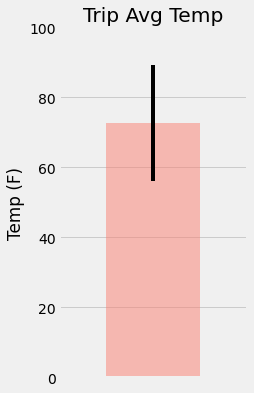

In [12]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

plt.figure(figsize = (3,6))
summary_df["avg"].plot(kind = "bar", color = "salmon", alpha = .5, grid = False)
plt.xticks(np.arange(1), labels = " ")
plt.ylim(0, 100)
plt.grid(axis = "y")
plt.errorbar(x = 0, y = avg_2013, yerr = dist, ecolor = "black")
plt.title("Trip Avg Temp")
plt.ylabel("Temp (F)")

plt.show()

### Daily Rainfall Average

In [13]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

session.query(Measurement.station, func.sum(Measurement.prcp), Station.name, Station.latitude, Station.longitude, Station.elevation)\
    .filter(Measurement.date >= '2013-01-01')\
    .filter(Measurement.date <= '2013-12-31')\
    .group_by(Measurement.station).order_by(func.sum(Measurement.prcp).desc())\
    .all()

C:\Users\Matt\anaconda\envs\PythonData\lib\site-packages\sqlalchemy\sql\compiler.py:362: SAWarning: SELECT statement has a cartesian product between FROM element(s) "measurement" and FROM element "station".  Apply join condition(s) between each element to resolve.
  util.warn(message)


[('USC00516128', 1231.2000000000016, 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 ('USC00519281', 801.2699999999905, 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 ('USC00513117', 424.97999999999803, 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 ('USC00519523', 356.93999999999994, 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 ('USC00514830', 251.7300000000004, 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 ('USC00519397', 173.2500000000005, 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 ('USC00511918', 159.21000000000015, 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 ('USC00517948', 51.12, 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 ('USC00518838', 13.680000000000005, 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0)]

In [14]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [15]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2017-08-01'
end_date = '2017-08-07'

# Use the start and end date to create a range of dates
dr_raw = pd.date_range(dt.date(2017, 8, 1), periods = 7).to_list()

# Strip off the year and save a list of strings in the format %m-%d
dr = [x.strftime("%m-%d") for x in dr_raw]

# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.

normals = []

for i in range(len(dr)):
        normals.append(daily_normals(dr[i]))
        
print(normals)

[[(67.0, 75.54, 83.0)], [(68.0, 75.60377358490567, 84.0)], [(70.0, 76.61111111111111, 85.0)], [(69.0, 76.71153846153847, 84.0)], [(69.0, 76.14814814814815, 82.0)], [(67.0, 76.25, 83.0)], [(71.0, 77.15686274509804, 83.0)]]


In [17]:
#use list compresion to create list of tuples, making index simpler

out = [item for x in normals for item in x]

#create seperate list for each descriptive statistic
mins = []
avgs = []
maxs = []

for i in range(len(out)):
    mins.append(out[i][0])
    avgs.append(out[i][1])
    maxs.append(out[i][2])

In [18]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

dr_full = [x.strftime("%Y-%m-%d") for x in dr_raw]

df = pd.DataFrame({"tmin":mins, "tavg":avgs, "tmax":maxs}, index = dr_full)
display(df)

,tmin,tavg,tmax
2017-08-01,67.0,75.540000,83.0
2017-08-02,68.0,75.603774,84.0
2017-08-03,70.0,76.611111,85.0
2017-08-04,69.0,76.711538,84.0
2017-08-05,69.0,76.148148,82.0
2017-08-06,67.0,76.250000,83.0
2017-08-07,71.0,77.156863,83.0


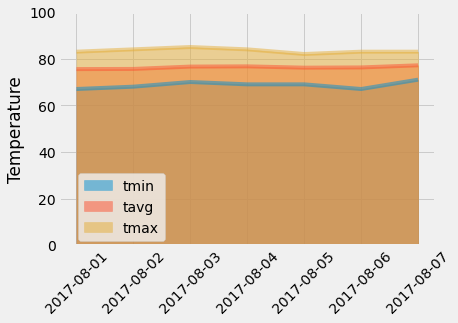

In [19]:
# Plot the daily normals as an area plot with `stacked=False`

df.plot(kind = "area", stacked = False, rot = 45)
plt.ylim(0, 100)
plt.ylabel("Temperature")
plt.legend(loc = (.05, .02))
plt.show()

## Close Session

In [ ]:
session.close()